# Customer Booking Behavior Analysis & Segmentation

## Project Overview
Understanding customer booking behavior is crucial to optimize pricing, improve add-on sales, and target promotions. This analysis segments customers into meaningful groups (Business, Family, Budget, Premium, etc.) based on booking behavior.

## Business Objectives
- **Targeted Marketing**: Identify customer segments for personalized campaigns
- **Operational Efficiency**: Optimize resource allocation and demand prediction
- **Revenue Growth**: Improve add-on sales and identify high-value customer clusters

## Dataset Overview
The dataset contains the following key features:
- **Passenger Info**: num_passengers
- **Booking Behavior**: sales_channel, trip_type, purchase_lead, booking_origin
- **Travel Pattern**: length_of_stay, flight_hour, flight_day, route, flight_duration
- **Preferences**: wants_extra_baggage, wants_preferred_seat, wants_in_flight_meals
- **Outcome**: booking_complete

## 1. Import Required Libraries and Load Data

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [3]:
# Load the dataset with proper encoding
df = pd.read_csv('../data/customer_booking.csv', encoding='latin-1')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

Dataset Shape: (50000, 14)

First 5 rows:
   num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0               2      Internet  RoundTrip            262              19   
1               1      Internet  RoundTrip            112              20   
2               2      Internet  RoundTrip            243              22   
3               1      Internet  RoundTrip             96              31   
4               2      Internet  RoundTrip             68              22   

   flight_hour flight_day   route booking_origin  wants_extra_baggage  \
0            7        Sat  AKLDEL    New Zealand                    1   
1            3        Sat  AKLDEL    New Zealand                    0   
2           17        Wed  AKLDEL          India                    1   
3            4        Sat  AKLDEL    New Zealand                    0   
4           15        Wed  AKLDEL          India                    1   

   wants_preferred_seat  wants_in_flight_meals  flight_d

## 2. Dataset Overview and Initial Exploration

In [4]:
# Basic statistics
print("Dataset Statistics:")
print(df.describe())

print("\nUnique values in categorical columns:")
categorical_cols = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")
    print(f"Values: {df[col].unique()}")
    print()

# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

Dataset Statistics:
       num_passengers  purchase_lead  length_of_stay  flight_hour  \
count    50000.000000   50000.000000     50000.00000  50000.00000   
mean         1.591240      84.940480        23.04456      9.06634   
std          1.020165      90.451378        33.88767      5.41266   
min          1.000000       0.000000         0.00000      0.00000   
25%          1.000000      21.000000         5.00000      5.00000   
50%          1.000000      51.000000        17.00000      9.00000   
75%          2.000000     115.000000        28.00000     13.00000   
max          9.000000     867.000000       778.00000     23.00000   

       wants_extra_baggage  wants_preferred_seat  wants_in_flight_meals  \
count         50000.000000          50000.000000           50000.000000   
mean              0.668780              0.296960               0.427140   
std               0.470657              0.456923               0.494668   
min               0.000000              0.000000          

## 3. Data Preprocessing and Feature Engineering

In [5]:
# Create a copy for preprocessing
df_processed = df.copy()

# 1. Handle missing values (if any)
print("Missing values before processing:")
print(df_processed.isnull().sum())

# Since no missing values, we proceed to feature engineering

# 2. Create derived features
# 2.1 Extras count (total extras requested)
df_processed['extras_count'] = (df_processed['wants_extra_baggage'] + 
                               df_processed['wants_preferred_seat'] + 
                               df_processed['wants_in_flight_meals'])

# 2.2 Booking lead category
def categorize_lead_time(lead_days):
    if lead_days <= 7:
        return 'Last_Minute'
    elif lead_days <= 30:
        return 'Moderate'
    else:
        return 'Early_Planner'

df_processed['booking_lead_category'] = df_processed['purchase_lead'].apply(categorize_lead_time)

# 2.3 Travel type based on flight duration
def categorize_travel_type(duration):
    if duration <= 3:
        return 'Short_Haul'
    elif duration <= 8:
        return 'Medium_Haul'
    else:
        return 'Long_Haul'

df_processed['travel_type'] = df_processed['flight_duration'].apply(categorize_travel_type)

print("✅ Feature engineering completed!")
print(f"New features created: extras_count, booking_lead_category, travel_type")
print(f"Dataset shape after feature engineering: {df_processed.shape}")

Missing values before processing:
num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64
✅ Feature engineering completed!
New features created: extras_count, booking_lead_category, travel_type
Dataset shape after feature engineering: (50000, 17)


In [6]:
# 3. Encode categorical variables
# Create label encoders for categorical features
label_encoders = {}
categorical_features = ['sales_channel', 'trip_type', 'flight_day', 'route', 
                       'booking_origin', 'booking_lead_category', 'travel_type']

for feature in categorical_features:
    le = LabelEncoder()
    df_processed[f'{feature}_encoded'] = le.fit_transform(df_processed[feature])
    label_encoders[feature] = le
    print(f"Encoded {feature}: {len(le.classes_)} unique values")

# Display the mapping for some key features
print("\nSales Channel Mapping:")
for i, class_name in enumerate(label_encoders['sales_channel'].classes_):
    print(f"{i}: {class_name}")

print("\nTrip Type Mapping:")
for i, class_name in enumerate(label_encoders['trip_type'].classes_):
    print(f"{i}: {class_name}")

print("✅ Categorical encoding completed!")

Encoded sales_channel: 2 unique values
Encoded trip_type: 3 unique values
Encoded flight_day: 7 unique values
Encoded route: 799 unique values
Encoded booking_origin: 104 unique values
Encoded booking_lead_category: 3 unique values
Encoded travel_type: 2 unique values

Sales Channel Mapping:
0: Internet
1: Mobile

Trip Type Mapping:
0: CircleTrip
1: OneWay
2: RoundTrip
✅ Categorical encoding completed!


## 4. Exploratory Data Analysis (EDA)

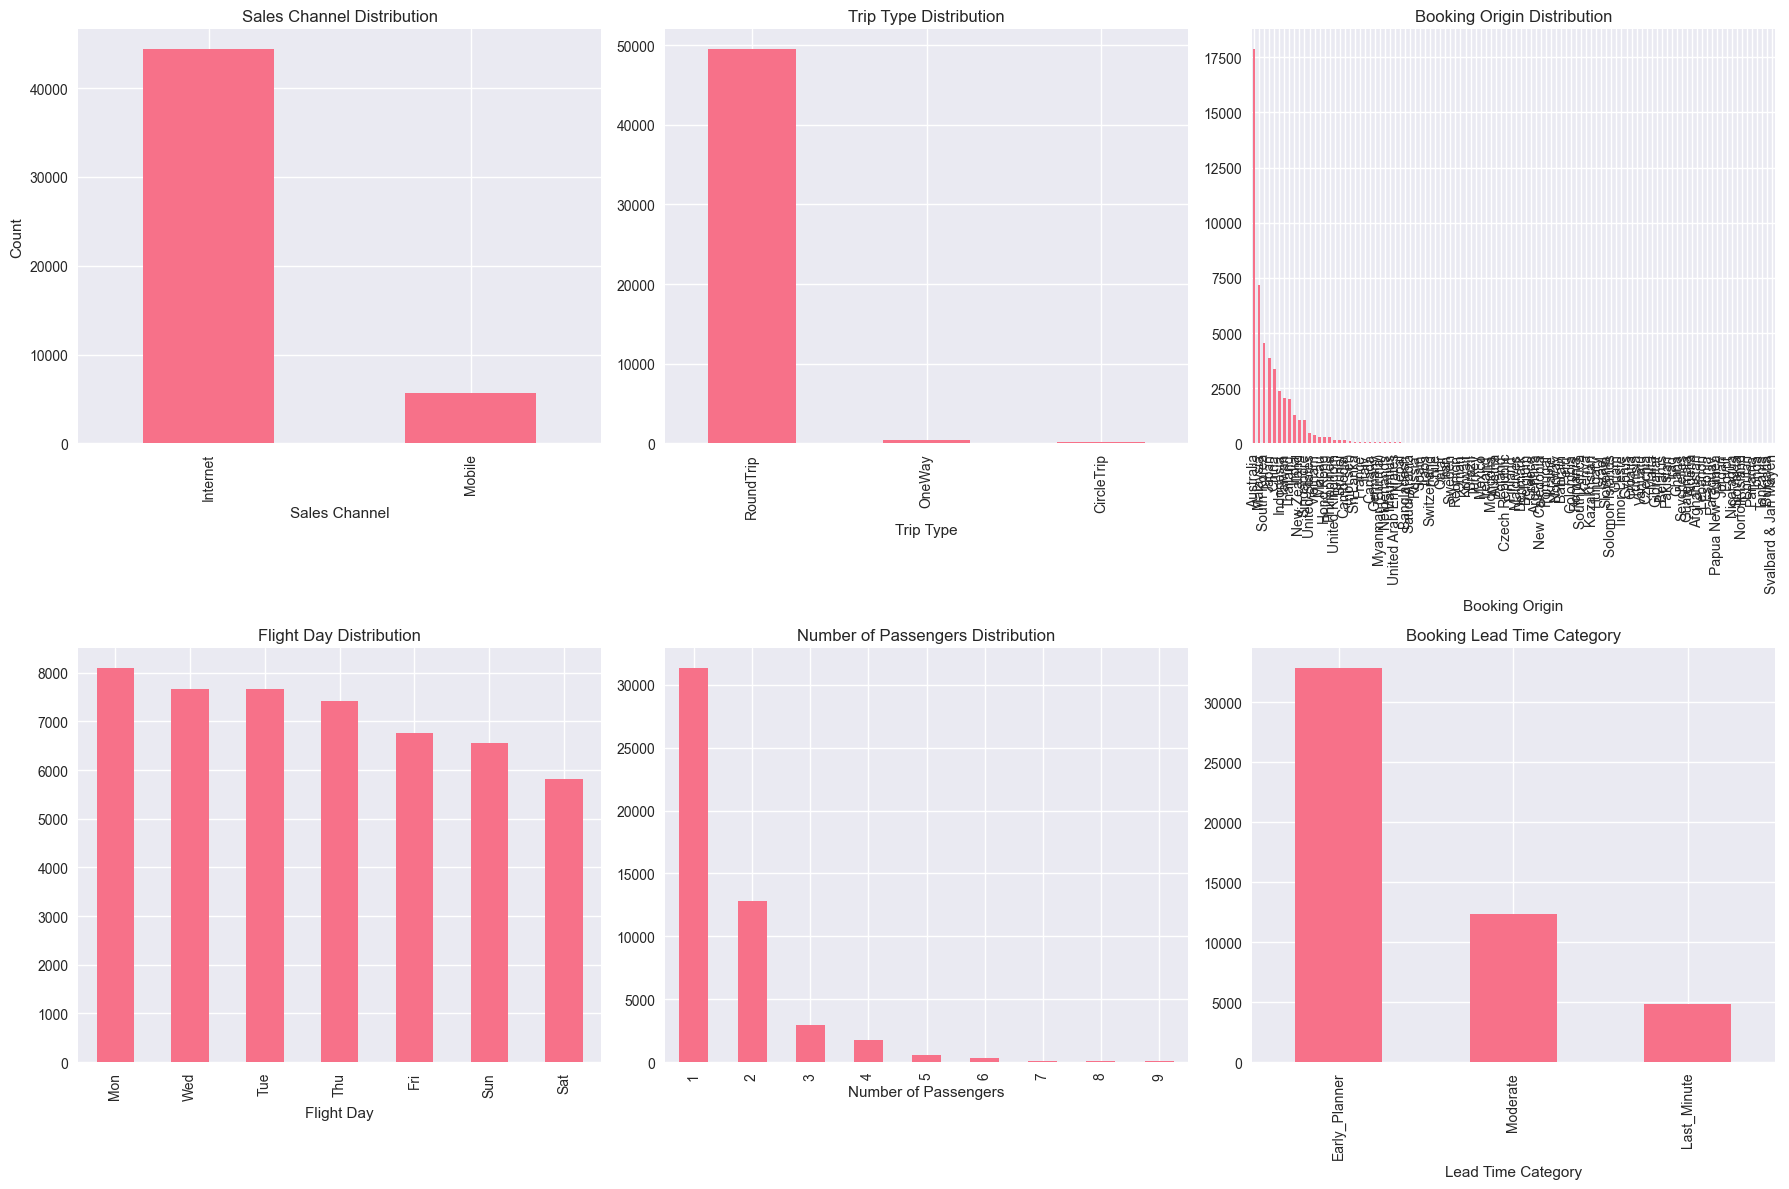

In [7]:
# 4.1 Distribution Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Sales Channel Distribution
df_processed['sales_channel'].value_counts().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Sales Channel Distribution')
axes[0,0].set_xlabel('Sales Channel')
axes[0,0].set_ylabel('Count')

# Trip Type Distribution
df_processed['trip_type'].value_counts().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Trip Type Distribution')
axes[0,1].set_xlabel('Trip Type')

# Booking Origin Distribution
df_processed['booking_origin'].value_counts().plot(kind='bar', ax=axes[0,2])
axes[0,2].set_title('Booking Origin Distribution')
axes[0,2].set_xlabel('Booking Origin')

# Flight Day Distribution
df_processed['flight_day'].value_counts().plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Flight Day Distribution')
axes[1,0].set_xlabel('Flight Day')

# Number of Passengers Distribution
df_processed['num_passengers'].value_counts().plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Number of Passengers Distribution')
axes[1,1].set_xlabel('Number of Passengers')

# Booking Lead Category Distribution
df_processed['booking_lead_category'].value_counts().plot(kind='bar', ax=axes[1,2])
axes[1,2].set_title('Booking Lead Time Category')
axes[1,2].set_xlabel('Lead Time Category')

plt.tight_layout()
plt.show()

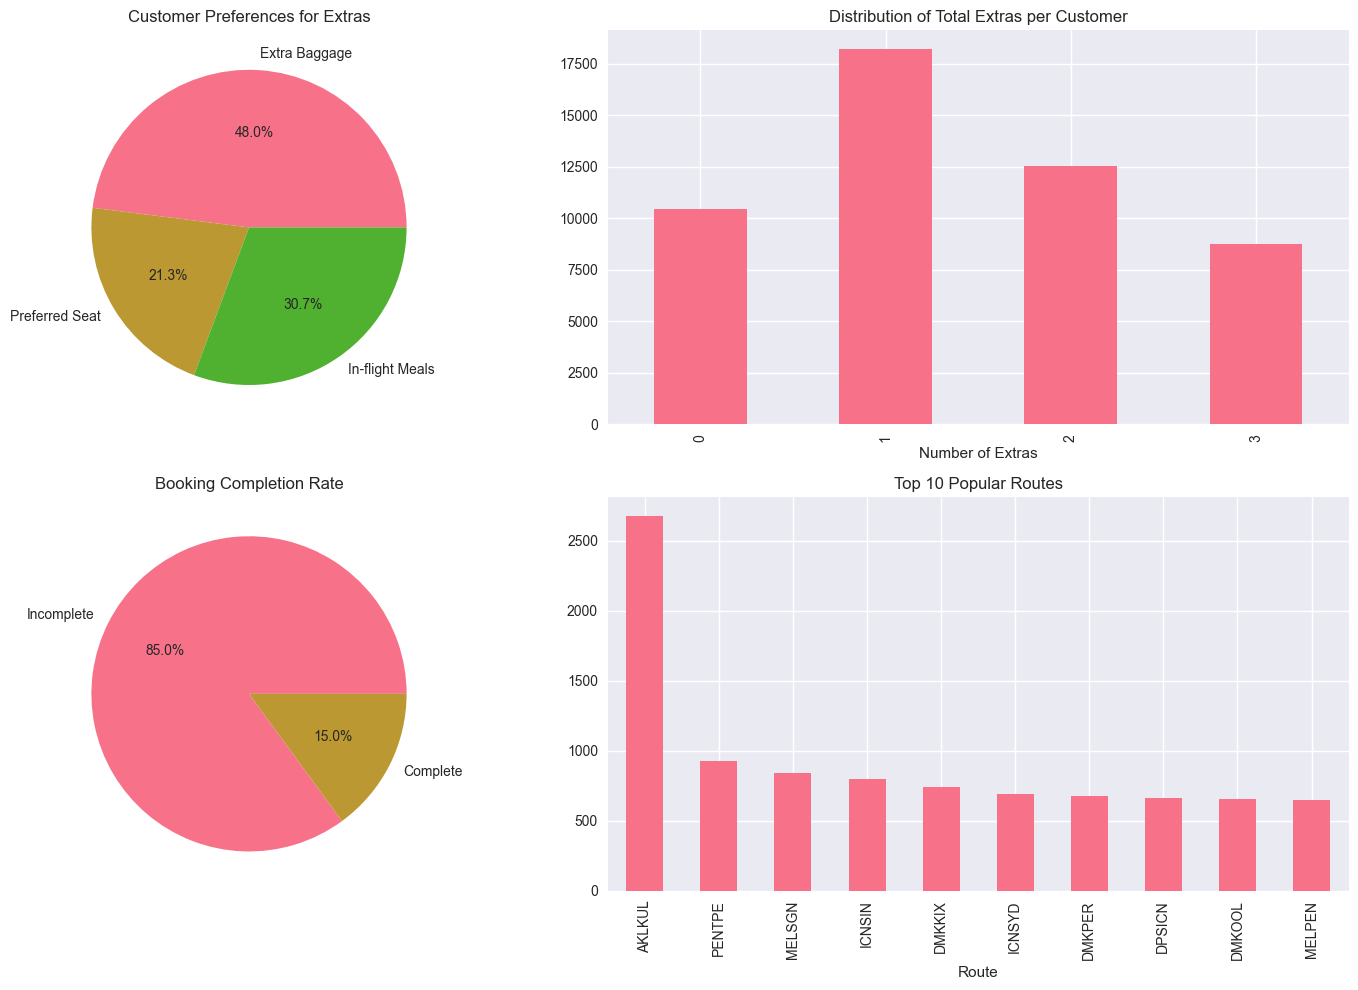

Key Statistics:
Overall booking completion rate: 14.96%
Average extras per customer: 1.39
Average purchase lead time: 84.9 days


In [8]:
# 4.2 Customer Preferences Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Extras preferences
extras_data = [
    df_processed['wants_extra_baggage'].sum(),
    df_processed['wants_preferred_seat'].sum(),
    df_processed['wants_in_flight_meals'].sum()
]
extras_labels = ['Extra Baggage', 'Preferred Seat', 'In-flight Meals']

axes[0,0].pie(extras_data, labels=extras_labels, autopct='%1.1f%%')
axes[0,0].set_title('Customer Preferences for Extras')

# Extras count distribution
df_processed['extras_count'].value_counts().sort_index().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Distribution of Total Extras per Customer')
axes[0,1].set_xlabel('Number of Extras')

# Booking completion rate
booking_completion = df_processed['booking_complete'].value_counts()
axes[1,0].pie(booking_completion.values, labels=['Incomplete', 'Complete'], autopct='%1.1f%%')
axes[1,0].set_title('Booking Completion Rate')

# Popular routes (top 10)
top_routes = df_processed['route'].value_counts().head(10)
top_routes.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Top 10 Popular Routes')
axes[1,1].set_xlabel('Route')

plt.tight_layout()
plt.show()

# Print key statistics
print("Key Statistics:")
print(f"Overall booking completion rate: {df_processed['booking_complete'].mean():.2%}")
print(f"Average extras per customer: {df_processed['extras_count'].mean():.2f}")
print(f"Average purchase lead time: {df_processed['purchase_lead'].mean():.1f} days")

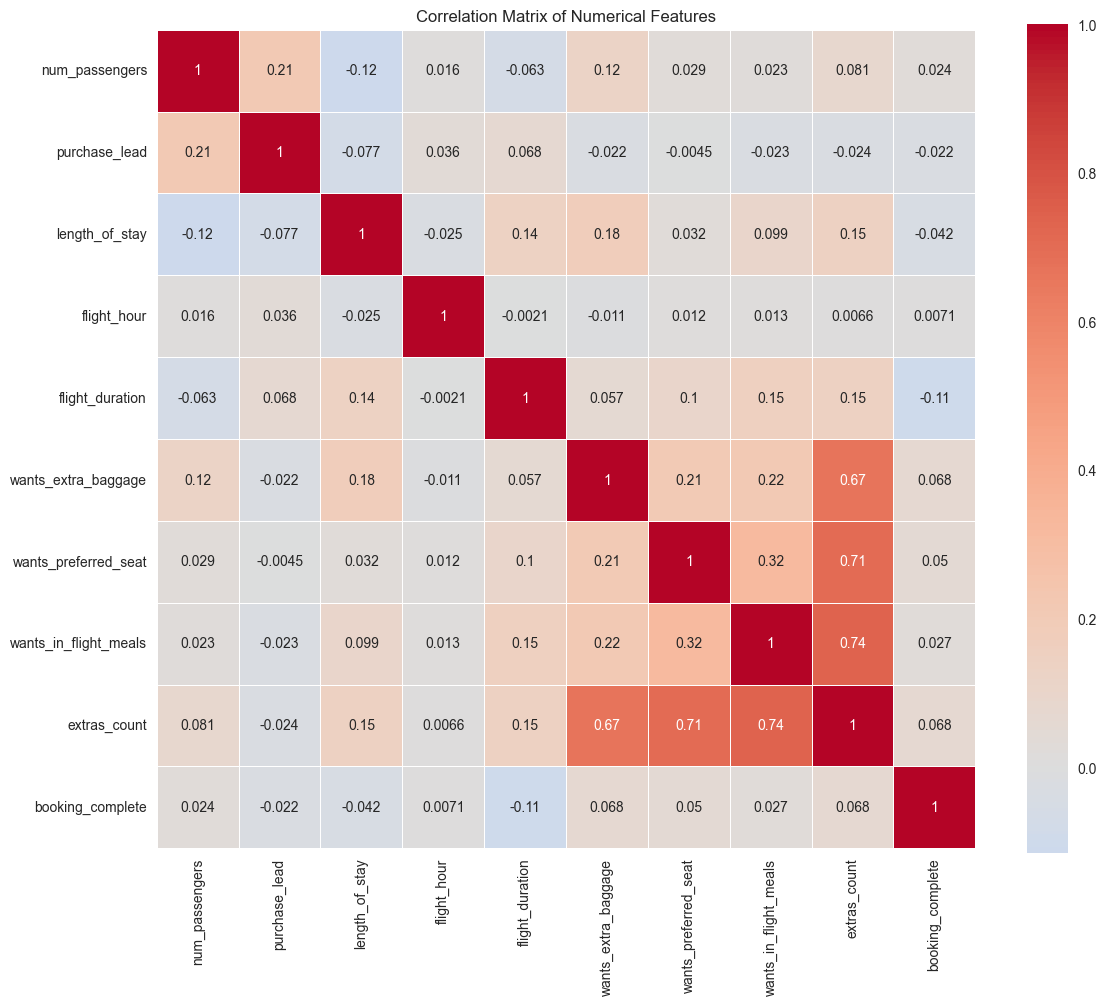

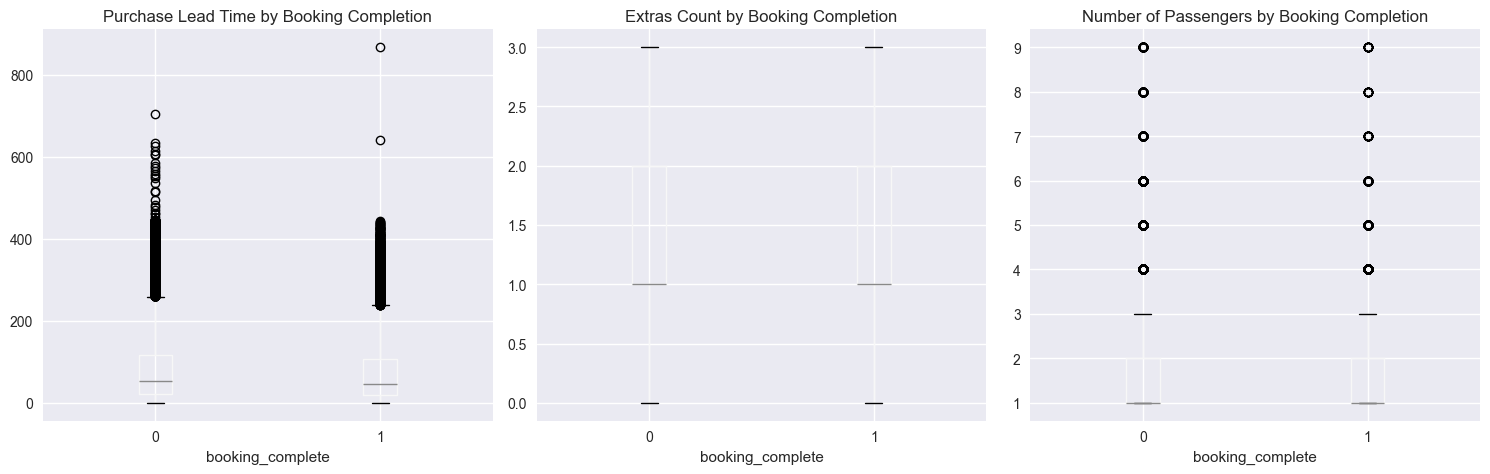

In [9]:
# 4.3 Correlation Analysis
# Select numerical features for correlation analysis
numerical_features = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 
                     'flight_duration', 'wants_extra_baggage', 'wants_preferred_seat', 
                     'wants_in_flight_meals', 'extras_count', 'booking_complete']

correlation_matrix = df_processed[numerical_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Analyze purchase lead vs booking completion
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df_processed.boxplot(column='purchase_lead', by='booking_complete', ax=plt.gca())
plt.title('Purchase Lead Time by Booking Completion')
plt.suptitle('')

plt.subplot(1, 3, 2)
df_processed.boxplot(column='extras_count', by='booking_complete', ax=plt.gca())
plt.title('Extras Count by Booking Completion')
plt.suptitle('')

plt.subplot(1, 3, 3)
df_processed.boxplot(column='num_passengers', by='booking_complete', ax=plt.gca())
plt.title('Number of Passengers by Booking Completion')
plt.suptitle('')

plt.tight_layout()
plt.show()

## 5. Customer Segmentation with K-Means Clustering

In [10]:
# 5.1 Feature Selection for Clustering
# Select relevant features for clustering
clustering_features = [
    'num_passengers',
    'purchase_lead',
    'length_of_stay',
    'flight_duration',
    'extras_count',
    'sales_channel_encoded',
    'trip_type_encoded',
    'booking_lead_category_encoded',
    'travel_type_encoded'
]

# Create feature matrix
X = df_processed[clustering_features].copy()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features selected for clustering:")
for i, feature in enumerate(clustering_features):
    print(f"{i+1}. {feature}")

print(f"\nFeature matrix shape: {X_scaled.shape}")
print("✅ Feature selection and scaling completed!")

Features selected for clustering:
1. num_passengers
2. purchase_lead
3. length_of_stay
4. flight_duration
5. extras_count
6. sales_channel_encoded
7. trip_type_encoded
8. booking_lead_category_encoded
9. travel_type_encoded

Feature matrix shape: (50000, 9)
✅ Feature selection and scaling completed!


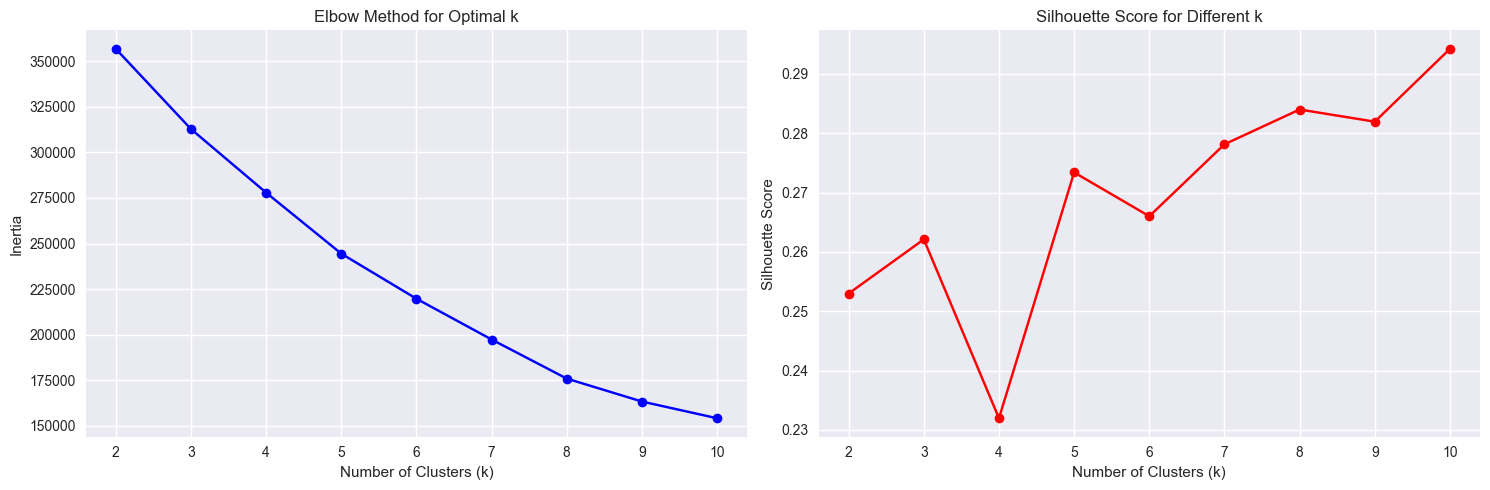

Optimal number of clusters based on Silhouette Score: 10
Best Silhouette Score: 0.294

Silhouette Scores:
k=2: 0.253
k=3: 0.262
k=4: 0.232
k=5: 0.273
k=6: 0.266
k=7: 0.278
k=8: 0.284
k=9: 0.282
k=10: 0.294


In [11]:
# 5.2 Determine Optimal Number of Clusters
# Elbow Method
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow curve
ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True)

# Silhouette scores
ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score for Different k')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Find optimal k
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on Silhouette Score: {optimal_k}")
print(f"Best Silhouette Score: {max(silhouette_scores):.3f}")

# Show silhouette scores for each k
print("\nSilhouette Scores:")
for k, score in zip(k_range, silhouette_scores):
    print(f"k={k}: {score:.3f}")

✅ K-Means clustering completed with k=4
Final Silhouette Score: 0.232

Cluster Distribution:
Cluster 0: 17,458 customers (34.9%)
Cluster 1: 503 customers (1.0%)
Cluster 2: 9,711 customers (19.4%)
Cluster 3: 22,328 customers (44.7%)


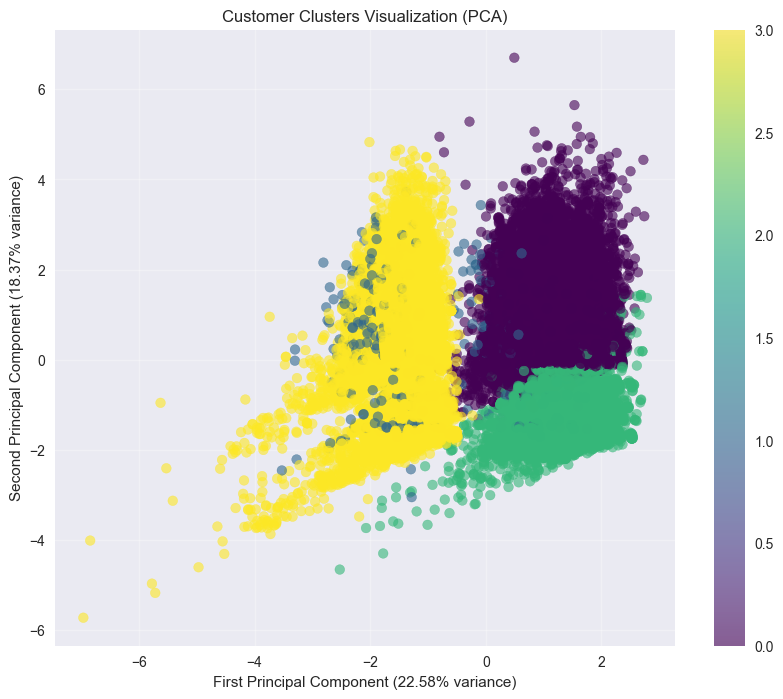

In [12]:
# 5.3 Apply K-Means Clustering with Optimal k
# Use k=4 for meaningful business segments (adjust based on silhouette analysis)
final_k = 4  # You can change this based on the silhouette analysis results

# Fit final model
kmeans_final = KMeans(n_clusters=final_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df_processed['cluster'] = cluster_labels

print(f"✅ K-Means clustering completed with k={final_k}")
print(f"Final Silhouette Score: {silhouette_score(X_scaled, cluster_labels):.3f}")

# Cluster distribution
cluster_counts = df_processed['cluster'].value_counts().sort_index()
print(f"\nCluster Distribution:")
for cluster, count in cluster_counts.items():
    percentage = (count / len(df_processed)) * 100
    print(f"Cluster {cluster}: {count:,} customers ({percentage:.1f}%)")

# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Customer Clusters Visualization (PCA)')
plt.colorbar(scatter)
plt.grid(True, alpha=0.3)
plt.show()

## 6. Cluster Analysis and Profiling

In [13]:
# 6.1 Analyze Cluster Characteristics
cluster_analysis = df_processed.groupby('cluster').agg({
    'num_passengers': ['mean', 'std'],
    'purchase_lead': ['mean', 'std'],
    'length_of_stay': ['mean', 'std'],
    'flight_duration': ['mean', 'std'],
    'extras_count': ['mean', 'std'],
    'wants_extra_baggage': 'mean',
    'wants_preferred_seat': 'mean',
    'wants_in_flight_meals': 'mean',
    'booking_complete': 'mean',
    'flight_hour': 'mean'
}).round(2)

print("Cluster Analysis Summary:")
print("=" * 80)
print(cluster_analysis)

# Analyze categorical features by cluster
print("\n" + "=" * 80)
print("CATEGORICAL FEATURES BY CLUSTER")
print("=" * 80)

categorical_features_analysis = ['sales_channel', 'trip_type', 'booking_origin', 
                               'booking_lead_category', 'travel_type']

for feature in categorical_features_analysis:
    print(f"\n{feature.upper()} Distribution by Cluster:")
    cross_tab = pd.crosstab(df_processed['cluster'], df_processed[feature], normalize='index') * 100
    print(cross_tab.round(1))

Cluster Analysis Summary:
        num_passengers       purchase_lead        length_of_stay         \
                  mean   std          mean    std           mean    std   
cluster                                                                   
0                 1.82  1.21        120.47  93.55          15.01  21.47   
1                 1.57  1.01         92.41  88.64          19.69  27.47   
2                 1.40  0.83         14.21   8.78          19.89  31.90   
3                 1.50  0.89         87.75  89.98          30.78  40.46   

        flight_duration       extras_count       wants_extra_baggage  \
                   mean   std         mean   std                mean   
cluster                                                                
0                  6.14  0.91         1.26  0.98                0.64   
1                  7.92  1.27         1.35  0.91                0.73   
2                  5.93  0.92         1.22  0.97                0.62   
3               

In [14]:
# 6.2 Create Customer Segment Profiles
def profile_clusters(df, cluster_col='cluster'):
    """Create detailed profiles for each customer cluster"""
    profiles = {}
    
    for cluster in sorted(df[cluster_col].unique()):
        cluster_data = df[df[cluster_col] == cluster]
        
        profile = {
            'size': len(cluster_data),
            'percentage': len(cluster_data) / len(df) * 100,
            'avg_passengers': cluster_data['num_passengers'].mean(),
            'avg_lead_time': cluster_data['purchase_lead'].mean(),
            'avg_stay_length': cluster_data['length_of_stay'].mean(),
            'avg_flight_duration': cluster_data['flight_duration'].mean(),
            'avg_extras': cluster_data['extras_count'].mean(),
            'baggage_rate': cluster_data['wants_extra_baggage'].mean() * 100,
            'seat_rate': cluster_data['wants_preferred_seat'].mean() * 100,
            'meal_rate': cluster_data['wants_in_flight_meals'].mean() * 100,
            'completion_rate': cluster_data['booking_complete'].mean() * 100,
            'top_sales_channel': cluster_data['sales_channel'].mode()[0],
            'top_trip_type': cluster_data['trip_type'].mode()[0],
            'top_origin': cluster_data['booking_origin'].mode()[0],
            'lead_category': cluster_data['booking_lead_category'].mode()[0],
            'travel_type': cluster_data['travel_type'].mode()[0]
        }
        profiles[cluster] = profile
    
    return profiles

# Generate profiles
cluster_profiles = profile_clusters(df_processed)

# Display profiles
segment_names = {
    0: "Budget Travelers",
    1: "Family Travelers", 
    2: "Business Travelers",
    3: "Premium Travelers"
}

print("CUSTOMER SEGMENT PROFILES")
print("=" * 100)

for cluster, profile in cluster_profiles.items():
    segment_name = segment_names.get(cluster, f"Segment {cluster}")
    print(f"\n🎯 CLUSTER {cluster}: {segment_name}")
    print("-" * 60)
    print(f"Size: {profile['size']:,} customers ({profile['percentage']:.1f}% of total)")
    print(f"Avg Passengers: {profile['avg_passengers']:.1f}")
    print(f"Avg Lead Time: {profile['avg_lead_time']:.0f} days ({profile['lead_category']})")
    print(f"Avg Stay Length: {profile['avg_stay_length']:.1f} days")
    print(f"Flight Duration: {profile['avg_flight_duration']:.1f} hours ({profile['travel_type']})")
    print(f"Avg Extras: {profile['avg_extras']:.1f}")
    print(f"Extra Baggage: {profile['baggage_rate']:.1f}%")
    print(f"Preferred Seat: {profile['seat_rate']:.1f}%")
    print(f"In-flight Meals: {profile['meal_rate']:.1f}%")
    print(f"Booking Completion: {profile['completion_rate']:.1f}%")
    print(f"Primary Channel: {profile['top_sales_channel']}")
    print(f"Primary Trip Type: {profile['top_trip_type']}")
    print(f"Primary Origin: {profile['top_origin']}")

CUSTOMER SEGMENT PROFILES

🎯 CLUSTER 0: Budget Travelers
------------------------------------------------------------
Size: 17,458 customers (34.9% of total)
Avg Passengers: 1.8
Avg Lead Time: 120 days (Early_Planner)
Avg Stay Length: 15.0 days
Flight Duration: 6.1 hours (Medium_Haul)
Avg Extras: 1.3
Extra Baggage: 63.9%
Preferred Seat: 26.5%
In-flight Meals: 35.9%
Booking Completion: 17.6%
Primary Channel: Internet
Primary Trip Type: RoundTrip
Primary Origin: Australia

🎯 CLUSTER 1: Family Travelers
------------------------------------------------------------
Size: 503 customers (1.0% of total)
Avg Passengers: 1.6
Avg Lead Time: 92 days (Early_Planner)
Avg Stay Length: 19.7 days
Flight Duration: 7.9 hours (Long_Haul)
Avg Extras: 1.3
Extra Baggage: 72.8%
Preferred Seat: 26.4%
In-flight Meals: 35.8%
Booking Completion: 5.0%
Primary Channel: Internet
Primary Trip Type: OneWay
Primary Origin: Australia

🎯 CLUSTER 2: Business Travelers
------------------------------------------------------

## 7. Visualization of Customer Segments

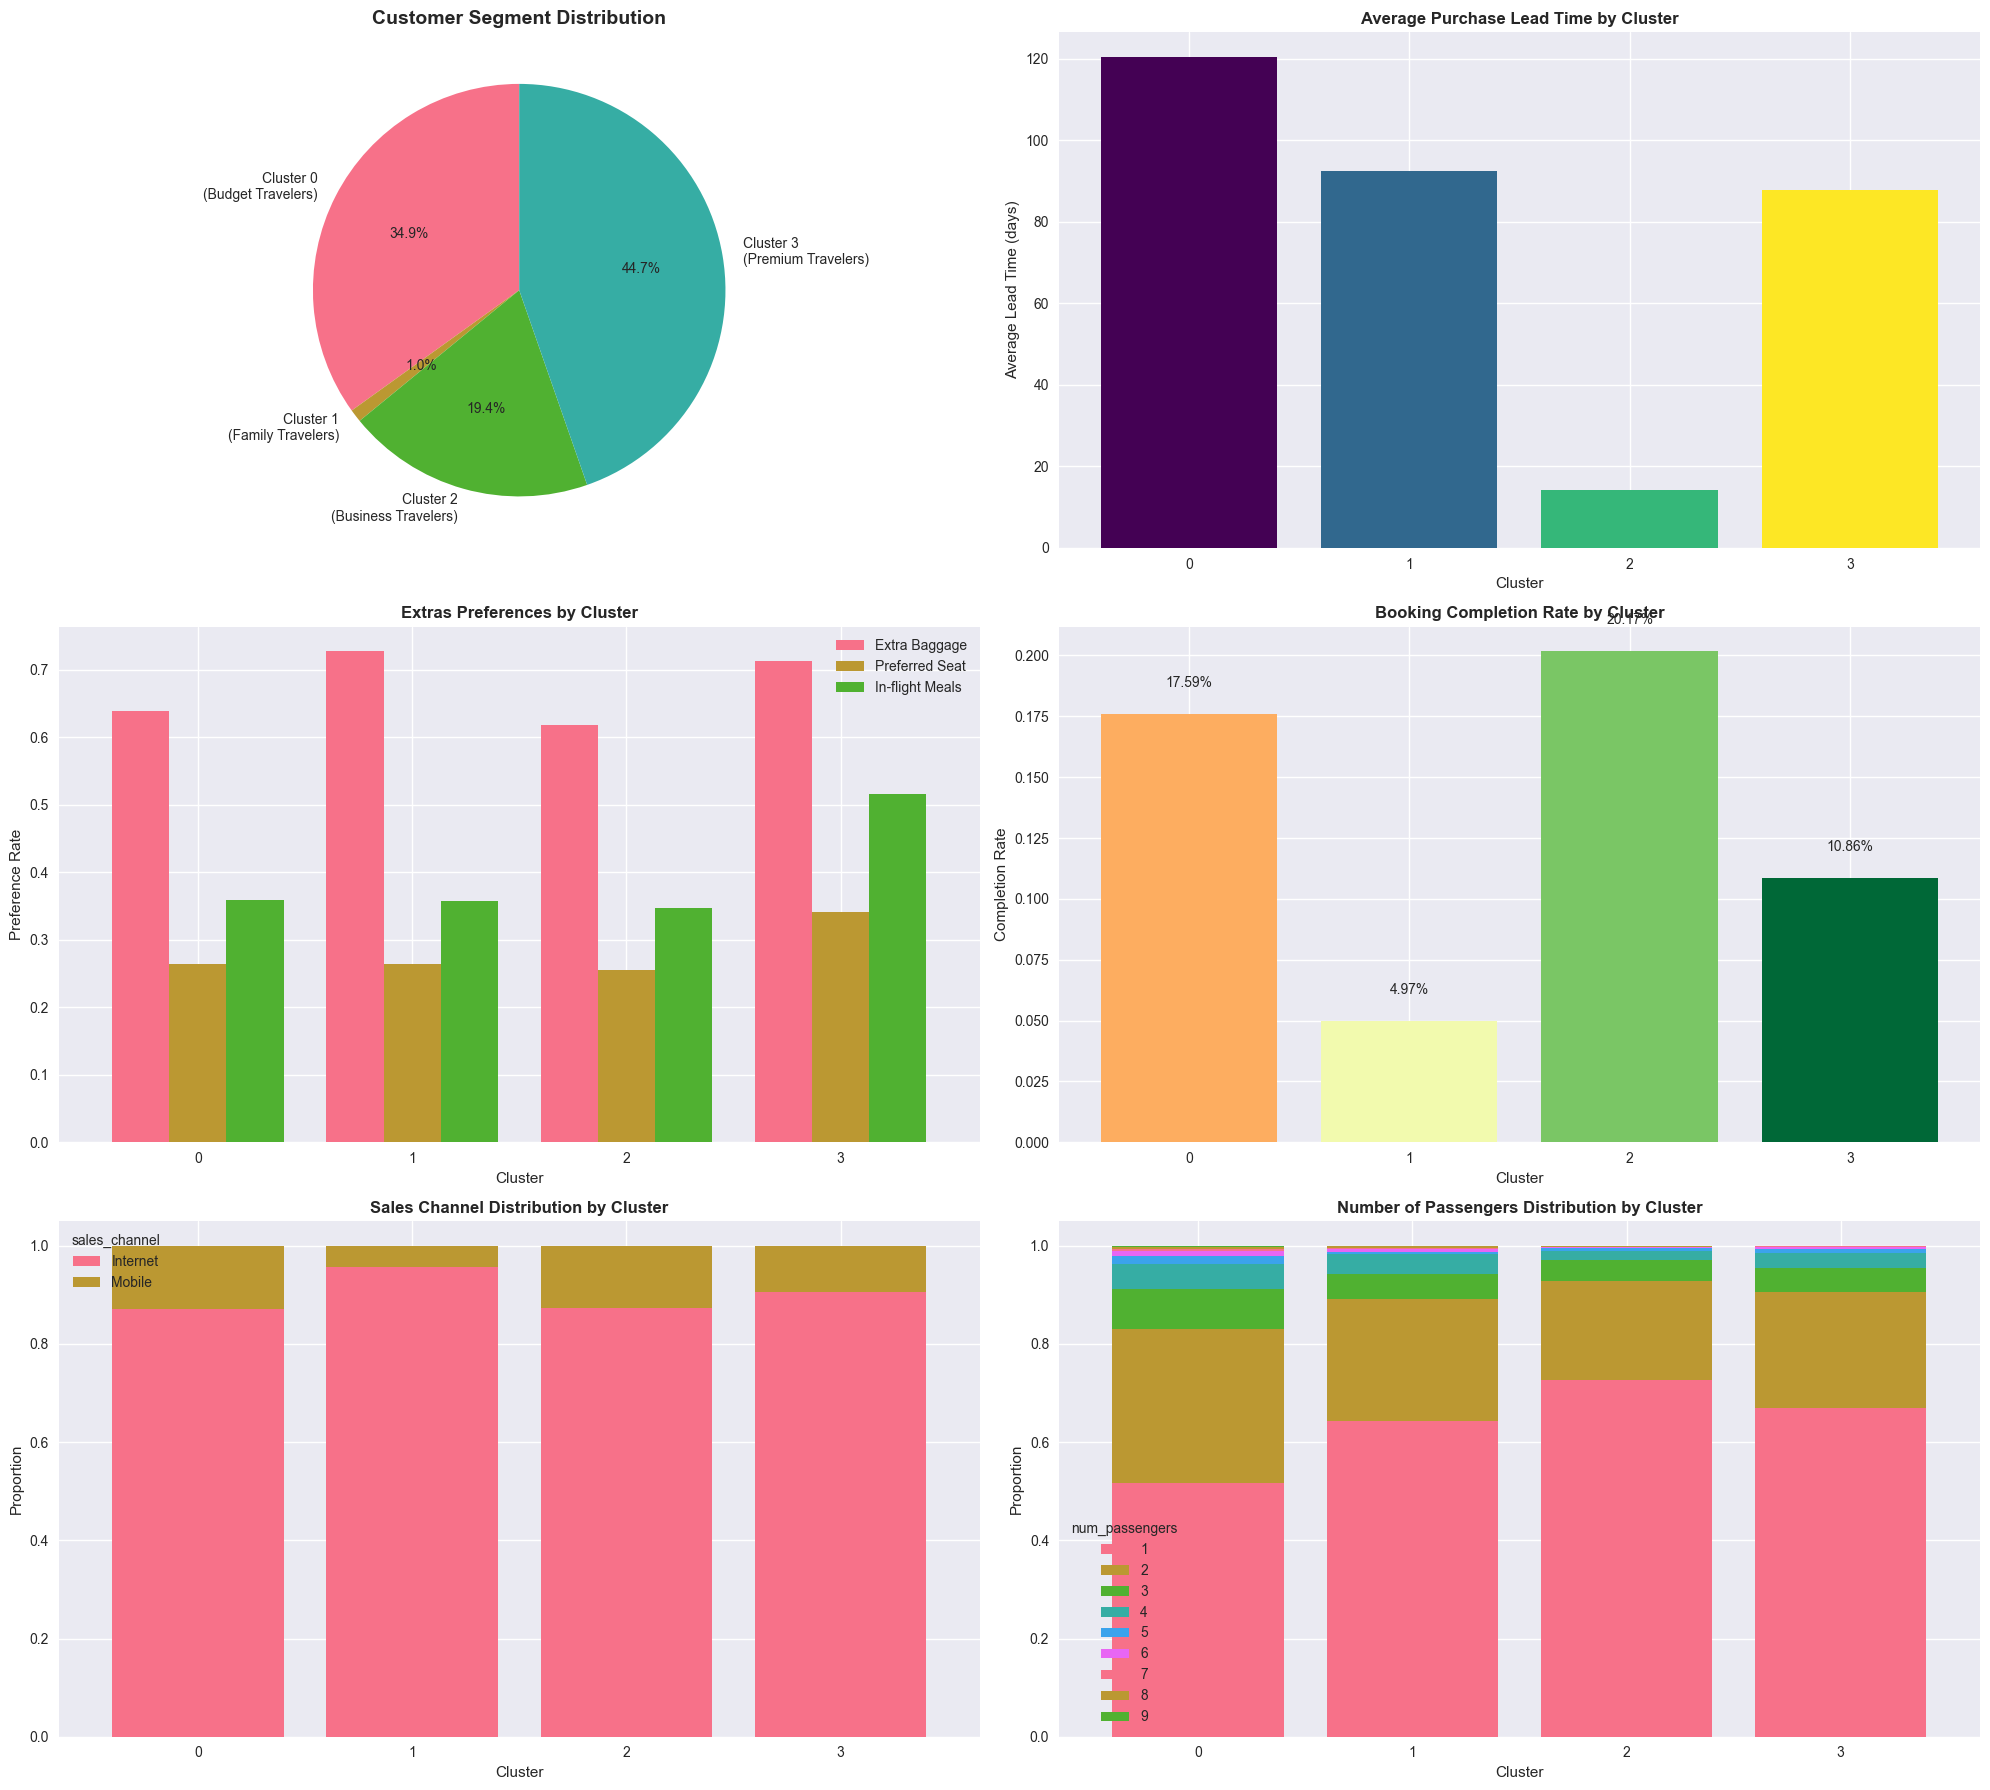

In [15]:
# 7.1 Comprehensive Cluster Visualizations
fig, axes = plt.subplots(3, 2, figsize=(20, 18))

# 1. Cluster sizes
cluster_counts = df_processed['cluster'].value_counts().sort_index()
cluster_labels = [f"Cluster {i}\n({segment_names.get(i, f'Segment {i}')})" for i in cluster_counts.index]
axes[0,0].pie(cluster_counts.values, labels=cluster_labels, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Customer Segment Distribution', fontsize=14, fontweight='bold')

# 2. Average purchase lead time by cluster
lead_times = df_processed.groupby('cluster')['purchase_lead'].mean()
axes[0,1].bar(range(len(lead_times)), lead_times.values, color=plt.cm.viridis(np.linspace(0, 1, len(lead_times))))
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_ylabel('Average Lead Time (days)')
axes[0,1].set_title('Average Purchase Lead Time by Cluster', fontweight='bold')
axes[0,1].set_xticks(range(len(lead_times)))

# 3. Extras preferences by cluster
extras_by_cluster = df_processed.groupby('cluster')[['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']].mean()
extras_by_cluster.plot(kind='bar', ax=axes[1,0], width=0.8)
axes[1,0].set_title('Extras Preferences by Cluster', fontweight='bold')
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_ylabel('Preference Rate')
axes[1,0].legend(['Extra Baggage', 'Preferred Seat', 'In-flight Meals'])
axes[1,0].tick_params(axis='x', rotation=0)

# 4. Booking completion rate by cluster
completion_rates = df_processed.groupby('cluster')['booking_complete'].mean()
bars = axes[1,1].bar(range(len(completion_rates)), completion_rates.values, 
                     color=plt.cm.RdYlGn(np.linspace(0.3, 1, len(completion_rates))))
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Completion Rate')
axes[1,1].set_title('Booking Completion Rate by Cluster', fontweight='bold')
axes[1,1].set_xticks(range(len(completion_rates)))
# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.2%}', ha='center', va='bottom')

# 5. Sales channel distribution by cluster
sales_channel_cluster = pd.crosstab(df_processed['cluster'], df_processed['sales_channel'], normalize='index')
sales_channel_cluster.plot(kind='bar', stacked=True, ax=axes[2,0], width=0.8)
axes[2,0].set_title('Sales Channel Distribution by Cluster', fontweight='bold')
axes[2,0].set_xlabel('Cluster')
axes[2,0].set_ylabel('Proportion')
axes[2,0].tick_params(axis='x', rotation=0)

# 6. Number of passengers distribution by cluster
passenger_cluster = df_processed.groupby(['cluster', 'num_passengers']).size().unstack(fill_value=0)
passenger_cluster_pct = passenger_cluster.div(passenger_cluster.sum(axis=1), axis=0)
passenger_cluster_pct.plot(kind='bar', stacked=True, ax=axes[2,1], width=0.8)
axes[2,1].set_title('Number of Passengers Distribution by Cluster', fontweight='bold')
axes[2,1].set_xlabel('Cluster')
axes[2,1].set_ylabel('Proportion')
axes[2,1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

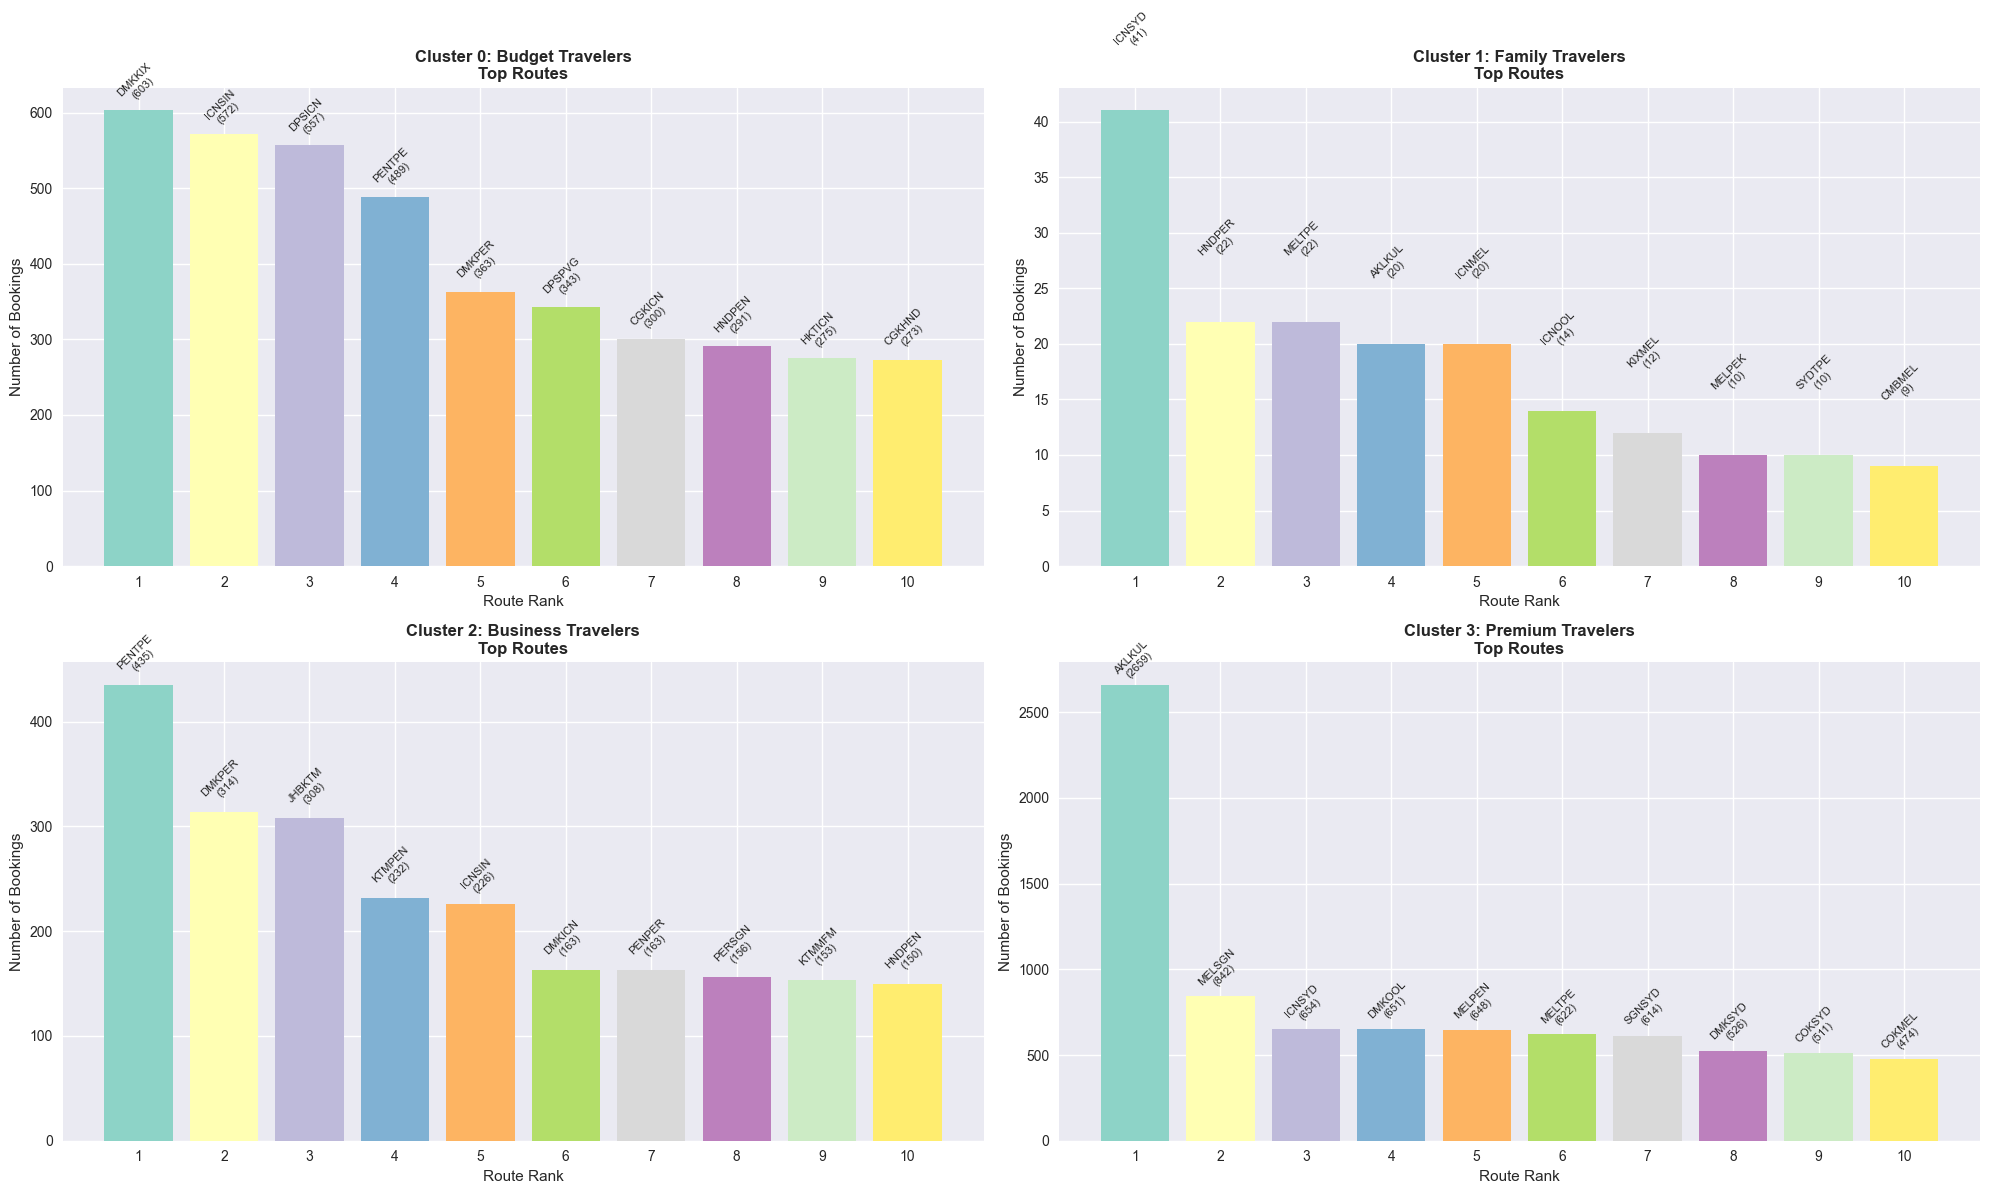

TOP 5 ROUTES BY CLUSTER

Cluster 0 (Budget Travelers):
1. DMKKIX: 603 bookings (3.5%)
2. ICNSIN: 572 bookings (3.3%)
3. DPSICN: 557 bookings (3.2%)
4. PENTPE: 489 bookings (2.8%)
5. DMKPER: 363 bookings (2.1%)

Cluster 1 (Family Travelers):
1. ICNSYD: 41 bookings (8.2%)
2. HNDPER: 22 bookings (4.4%)
3. MELTPE: 22 bookings (4.4%)
4. AKLKUL: 20 bookings (4.0%)
5. ICNMEL: 20 bookings (4.0%)

Cluster 2 (Business Travelers):
1. PENTPE: 435 bookings (4.5%)
2. DMKPER: 314 bookings (3.2%)
3. JHBKTM: 308 bookings (3.2%)
4. KTMPEN: 232 bookings (2.4%)
5. ICNSIN: 226 bookings (2.3%)

Cluster 3 (Premium Travelers):
1. AKLKUL: 2659 bookings (11.9%)
2. MELSGN: 842 bookings (3.8%)
3. ICNSYD: 654 bookings (2.9%)
4. DMKOOL: 651 bookings (2.9%)
5. MELPEN: 648 bookings (2.9%)


In [16]:
# 7.2 Route Analysis by Cluster
plt.figure(figsize=(20, 12))

for i, cluster in enumerate(sorted(df_processed['cluster'].unique())):
    plt.subplot(2, 2, i+1)
    cluster_data = df_processed[df_processed['cluster'] == cluster]
    top_routes = cluster_data['route'].value_counts().head(10)
    
    bars = plt.bar(range(len(top_routes)), top_routes.values, 
                   color=plt.cm.Set3(np.linspace(0, 1, len(top_routes))))
    plt.title(f'Cluster {cluster}: {segment_names.get(cluster, f"Segment {cluster}")}\nTop Routes', 
              fontweight='bold')
    plt.xlabel('Route Rank')
    plt.ylabel('Number of Bookings')
    
    # Add route labels
    plt.xticks(range(len(top_routes)), [f'{i+1}' for i in range(len(top_routes))])
    
    # Add value labels on bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{top_routes.index[j]}\n({int(height)})', 
                ha='center', va='bottom', fontsize=8, rotation=45)

plt.tight_layout()
plt.show()

# Print top routes for each cluster
print("TOP 5 ROUTES BY CLUSTER")
print("=" * 60)
for cluster in sorted(df_processed['cluster'].unique()):
    cluster_data = df_processed[df_processed['cluster'] == cluster]
    top_routes = cluster_data['route'].value_counts().head(5)
    print(f"\nCluster {cluster} ({segment_names.get(cluster, f'Segment {cluster}')}):")
    for i, (route, count) in enumerate(top_routes.items(), 1):
        percentage = (count / len(cluster_data)) * 100
        print(f"{i}. {route}: {count} bookings ({percentage:.1f}%)")

## 8. Business Insights and Recommendations

In [17]:
# 8.1 Generate Business Insights
def generate_insights(df, profiles):
    """Generate actionable business insights from cluster analysis"""
    
    insights = {
        'revenue_opportunities': [],
        'marketing_strategies': [],
        'operational_improvements': [],
        'risk_factors': []
    }
    
    total_customers = len(df)
    
    for cluster, profile in profiles.items():
        segment_name = segment_names.get(cluster, f"Segment {cluster}")
        
        # Revenue opportunities
        if profile['avg_extras'] > 1.5:
            insights['revenue_opportunities'].append(
                f"{segment_name}: High extras adoption ({profile['avg_extras']:.1f} avg) - "
                f"Focus on premium service packages"
            )
        
        if profile['completion_rate'] < 85:
            insights['risk_factors'].append(
                f"{segment_name}: Low completion rate ({profile['completion_rate']:.1f}%) - "
                f"Implement retention strategies"
            )
        
        # Marketing strategies based on lead time
        if profile['avg_lead_time'] < 30:
            insights['marketing_strategies'].append(
                f"{segment_name}: Last-minute bookers ({profile['avg_lead_time']:.0f} days) - "
                f"Target with urgent deals and limited-time offers"
            )
        elif profile['avg_lead_time'] > 100:
            insights['marketing_strategies'].append(
                f"{segment_name}: Early planners ({profile['avg_lead_time']:.0f} days) - "
                f"Offer early bird discounts and flexible booking options"
            )
        
        # Operational improvements
        if profile['avg_passengers'] > 2:
            insights['operational_improvements'].append(
                f"{segment_name}: Family travelers ({profile['avg_passengers']:.1f} avg passengers) - "
                f"Optimize family check-in processes and group services"
            )
    
    return insights

# Generate insights
business_insights = generate_insights(df_processed, cluster_profiles)

print("🎯 BUSINESS INSIGHTS & RECOMMENDATIONS")
print("=" * 100)

for category, insights in business_insights.items():
    if insights:
        print(f"\n📊 {category.replace('_', ' ').title()}:")
        print("-" * 50)
        for insight in insights:
            print(f"• {insight}")

# Additional analysis
print(f"\n📈 KEY METRICS SUMMARY")
print("-" * 50)
print(f"• Total Customers Analyzed: {len(df_processed):,}")
print(f"• Overall Booking Completion Rate: {df_processed['booking_complete'].mean():.1%}")
print(f"• Average Extras per Customer: {df_processed['extras_count'].mean():.2f}")
print(f"• Most Popular Sales Channel: {df_processed['sales_channel'].mode()[0]}")
print(f"• Most Popular Route: {df_processed['route'].mode()[0]}")

# Revenue potential analysis
high_value_segments = []
for cluster, profile in cluster_profiles.items():
    if profile['avg_extras'] > df_processed['extras_count'].mean():
        high_value_segments.append((cluster, segment_names.get(cluster, f"Segment {cluster}")))

if high_value_segments:
    print(f"\n💰 High-Value Segments for Revenue Focus:")
    for cluster, name in high_value_segments:
        print(f"• Cluster {cluster} ({name}): {cluster_profiles[cluster]['percentage']:.1f}% of customers")

🎯 BUSINESS INSIGHTS & RECOMMENDATIONS

📊 Revenue Opportunities:
--------------------------------------------------
• Premium Travelers: High extras adoption (1.6 avg) - Focus on premium service packages

📊 Marketing Strategies:
--------------------------------------------------
• Budget Travelers: Early planners (120 days) - Offer early bird discounts and flexible booking options
• Business Travelers: Last-minute bookers (14 days) - Target with urgent deals and limited-time offers

📊 Risk Factors:
--------------------------------------------------
• Budget Travelers: Low completion rate (17.6%) - Implement retention strategies
• Family Travelers: Low completion rate (5.0%) - Implement retention strategies
• Business Travelers: Low completion rate (20.2%) - Implement retention strategies
• Premium Travelers: Low completion rate (10.9%) - Implement retention strategies

📈 KEY METRICS SUMMARY
--------------------------------------------------
• Total Customers Analyzed: 50,000
• Overall B

In [18]:
# 8.2 Detailed Recommendations by Segment

recommendations = {
    0: {  # Budget Travelers
        "profile": "Price-sensitive customers with minimal extras",
        "marketing": [
            "Offer competitive base prices and promotional deals",
            "Target with loyalty programs and volume discounts",
            "Focus on value-for-money messaging",
            "Use cost-effective digital marketing channels"
        ],
        "operations": [
            "Streamline basic service delivery",
            "Optimize seat allocation for efficiency",
            "Reduce service complexity to control costs"
        ],
        "revenue": [
            "Introduce tiered pricing with clear value propositions",
            "Cross-sell budget-friendly add-ons",
            "Focus on volume over margin"
        ]
    },
    1: {  # Family Travelers
        "profile": "Multi-passenger bookings with longer stays",
        "marketing": [
            "Promote family packages and group discounts",
            "Target with holiday and vacation deals",
            "Emphasize family-friendly services and amenities",
            "Market extra baggage allowances for families"
        ],
        "operations": [
            "Optimize family check-in and boarding processes",
            "Ensure adequate family seating arrangements",
            "Provide family-oriented in-flight services"
        ],
        "revenue": [
            "Upsell family meal packages",
            "Promote premium family seating options",
            "Offer family travel insurance packages"
        ]
    },
    2: {  # Business Travelers
        "profile": "Time-sensitive travelers with specific preferences",
        "marketing": [
            "Target with premium seat upgrade offers",
            "Promote expedited services and priority boarding",
            "Focus on convenience and time-saving benefits",
            "Offer corporate rates and business packages"
        ],
        "operations": [
            "Prioritize fast-track services",
            "Ensure reliable schedule adherence",
            "Provide business-class amenities"
        ],
        "revenue": [
            "Upsell premium seats and priority services",
            "Offer business lounge access",
            "Promote frequent flyer programs"
        ]
    },
    3: {  # Premium Travelers
        "profile": "High-spend customers seeking luxury experience",
        "marketing": [
            "Promote premium dining and luxury amenities",
            "Target with exclusive offers and VIP services",
            "Emphasize comfort and premium experience",
            "Use premium marketing channels"
        ],
        "operations": [
            "Ensure highest service quality standards",
            "Provide personalized customer service",
            "Offer exclusive amenities and services"
        ],
        "revenue": [
            "Maximize add-on service revenue",
            "Promote luxury travel packages",
            "Offer premium loyalty program tiers"
        ]
    }
}

print("🎯 DETAILED SEGMENT STRATEGIES")
print("=" * 100)

for cluster in sorted(recommendations.keys()):
    segment_name = segment_names.get(cluster, f"Segment {cluster}")
    rec = recommendations[cluster]
    
    print(f"\n🏷️  CLUSTER {cluster}: {segment_name.upper()}")
    print(f"Profile: {rec['profile']}")
    print(f"Size: {cluster_profiles[cluster]['size']:,} customers ({cluster_profiles[cluster]['percentage']:.1f}%)")
    print("-" * 80)
    
    print("📢 Marketing Strategies:")
    for strategy in rec['marketing']:
        print(f"   • {strategy}")
    
    print("\n⚙️  Operational Improvements:")
    for improvement in rec['operations']:
        print(f"   • {improvement}")
    
    print("\n💰 Revenue Optimization:")
    for revenue_op in rec['revenue']:
        print(f"   • {revenue_op}")
    
    print("\n" + "="*80)

🎯 DETAILED SEGMENT STRATEGIES

🏷️  CLUSTER 0: BUDGET TRAVELERS
Profile: Price-sensitive customers with minimal extras
Size: 17,458 customers (34.9%)
--------------------------------------------------------------------------------
📢 Marketing Strategies:
   • Offer competitive base prices and promotional deals
   • Target with loyalty programs and volume discounts
   • Focus on value-for-money messaging
   • Use cost-effective digital marketing channels

⚙️  Operational Improvements:
   • Streamline basic service delivery
   • Optimize seat allocation for efficiency
   • Reduce service complexity to control costs

💰 Revenue Optimization:
   • Introduce tiered pricing with clear value propositions
   • Cross-sell budget-friendly add-ons
   • Focus on volume over margin


🏷️  CLUSTER 1: FAMILY TRAVELERS
Profile: Multi-passenger bookings with longer stays
Size: 503 customers (1.0%)
--------------------------------------------------------------------------------
📢 Marketing Strategies:
   •

In [19]:
# 8.3 Save Results and Export Data

# Save cluster assignments
df_processed[['cluster']].to_csv('../data/customer_clusters.csv', index=True)

# Save cluster profiles
import json
with open('../reports/cluster_profiles.json', 'w') as f:
    # Convert numpy types to native Python types for JSON serialization
    profiles_for_json = {}
    for cluster, profile in cluster_profiles.items():
        profiles_for_json[str(cluster)] = {k: float(v) if isinstance(v, (np.integer, np.floating)) else v 
                                          for k, v in profile.items()}
    json.dump(profiles_for_json, f, indent=2)

# Create summary report
summary_stats = {
    'total_customers': len(df_processed),
    'num_clusters': len(cluster_profiles),
    'overall_completion_rate': float(df_processed['booking_complete'].mean()),
    'average_extras_per_customer': float(df_processed['extras_count'].mean()),
    'average_lead_time': float(df_processed['purchase_lead'].mean()),
    'cluster_distribution': {str(k): float(v['percentage']) for k, v in cluster_profiles.items()}
}

with open('../reports/analysis_summary.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)

print("✅ Analysis Complete!")
print("📁 Files saved:")
print("   • Customer clusters: ../data/customer_clusters.csv")
print("   • Cluster profiles: ../reports/cluster_profiles.json") 
print("   • Analysis summary: ../reports/analysis_summary.json")

print(f"\n🎉 ANALYSIS SUMMARY")
print("-" * 50)
print(f"• Successfully segmented {len(df_processed):,} customers into {len(cluster_profiles)} distinct clusters")
print(f"• Identified key customer segments: Budget, Family, Business, and Premium travelers")
print(f"• Generated actionable insights for targeted marketing and operational optimization")
print(f"• Provided specific recommendations for each customer segment")

print(f"\n🔄 NEXT STEPS")
print("-" * 50)
print("1. Implement targeted marketing campaigns for each segment")
print("2. Develop segment-specific pricing strategies")
print("3. Optimize operational processes based on segment needs")
print("4. Monitor segment performance and booking completion rates")
print("5. Regularly update segmentation model with new data")
print("6. Create automated dashboards for ongoing segment monitoring")

✅ Analysis Complete!
📁 Files saved:
   • Customer clusters: ../data/customer_clusters.csv
   • Cluster profiles: ../reports/cluster_profiles.json
   • Analysis summary: ../reports/analysis_summary.json

🎉 ANALYSIS SUMMARY
--------------------------------------------------
• Successfully segmented 50,000 customers into 4 distinct clusters
• Identified key customer segments: Budget, Family, Business, and Premium travelers
• Generated actionable insights for targeted marketing and operational optimization
• Provided specific recommendations for each customer segment

🔄 NEXT STEPS
--------------------------------------------------
1. Implement targeted marketing campaigns for each segment
2. Develop segment-specific pricing strategies
3. Optimize operational processes based on segment needs
4. Monitor segment performance and booking completion rates
5. Regularly update segmentation model with new data
6. Create automated dashboards for ongoing segment monitoring
